In [5]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima, ARIMA, model_selection




In [6]:
df = pd.read_csv("../CSVs/daily_revenue.csv", index_col="date", dayfirst=True, parse_dates=True)
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [7]:
df['revenue'] = df['revenue'].str.replace(',', '').astype(float)
df = df.asfreq('D')
df.index


DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq='D')

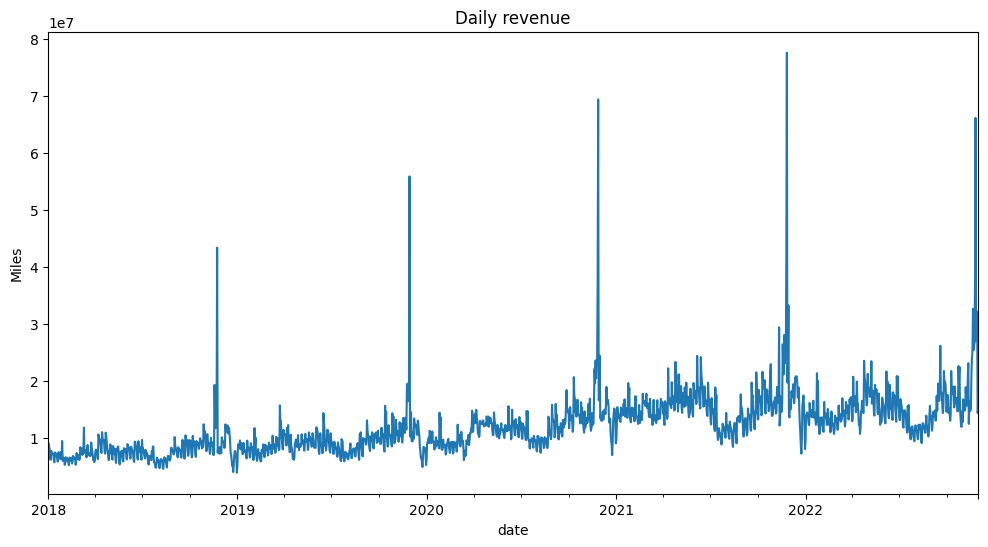

In [8]:
df['revenue'].plot(figsize=(12, 6), title='Daily revenue', ylabel='Miles')
plt.show()

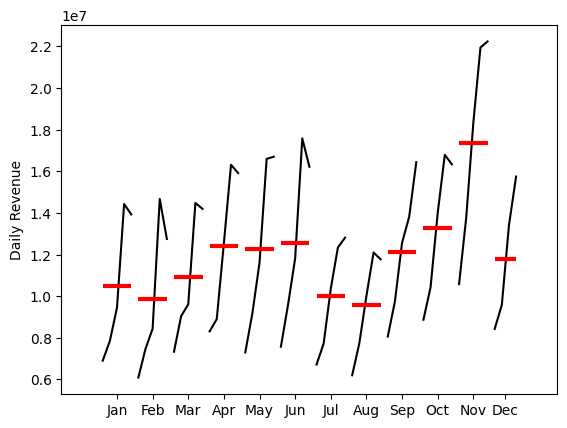

In [9]:
month_plot(df['revenue'].resample('ME').mean() ,ylabel='Daily Revenue')
plt.show()

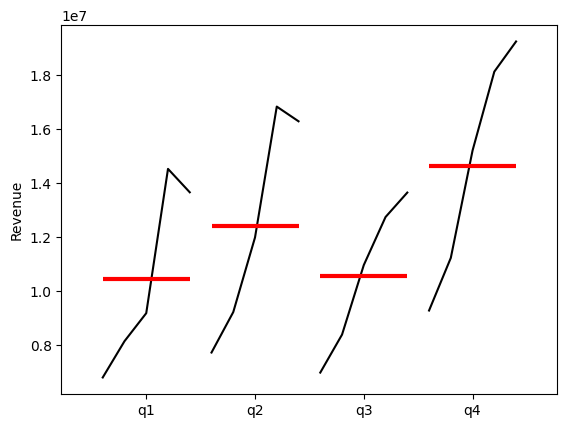

In [10]:
quarter_plot(df['revenue'].resample('QE').mean() ,ylabel='Revenue')
plt.show()

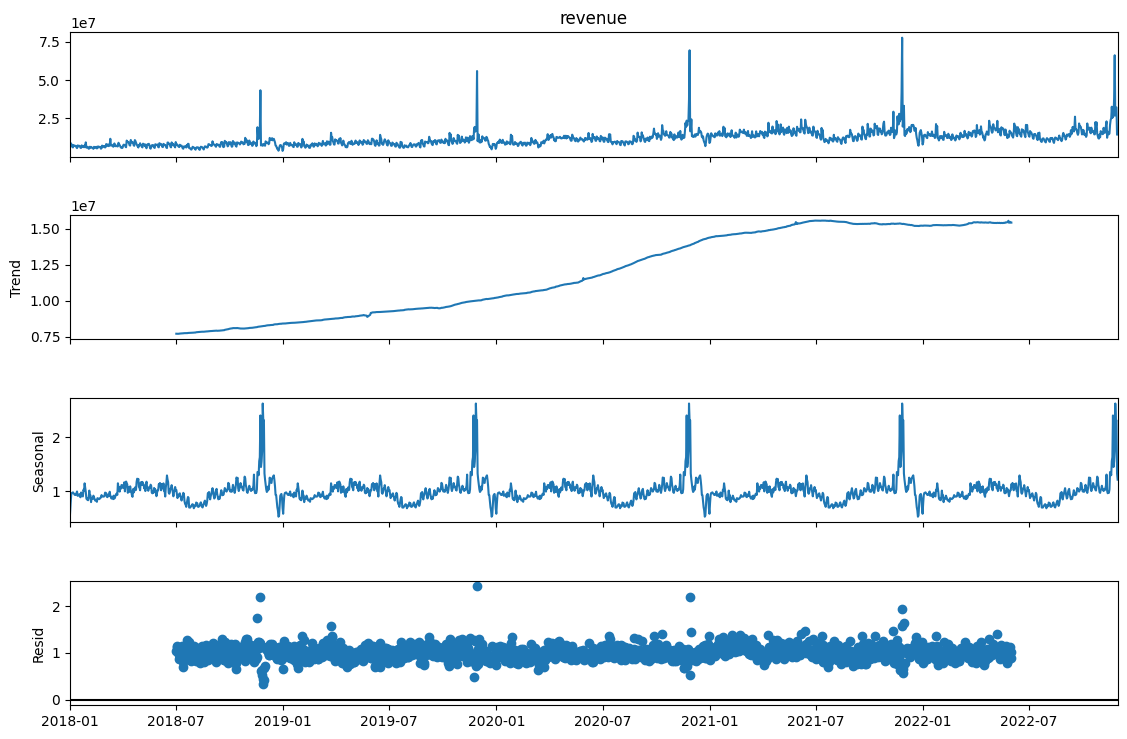

In [11]:
result = seasonal_decompose(df['revenue'], model='multiplicative', period=365)
fig = result.plot()
fig.set_size_inches(12, 8)
plt.show()

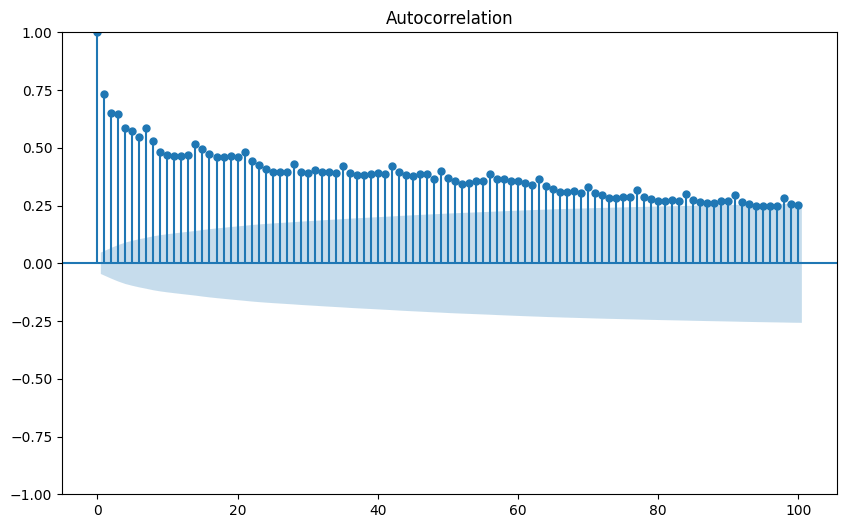

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(df['revenue'].dropna(), lags=100, ax=ax)
plt.show()

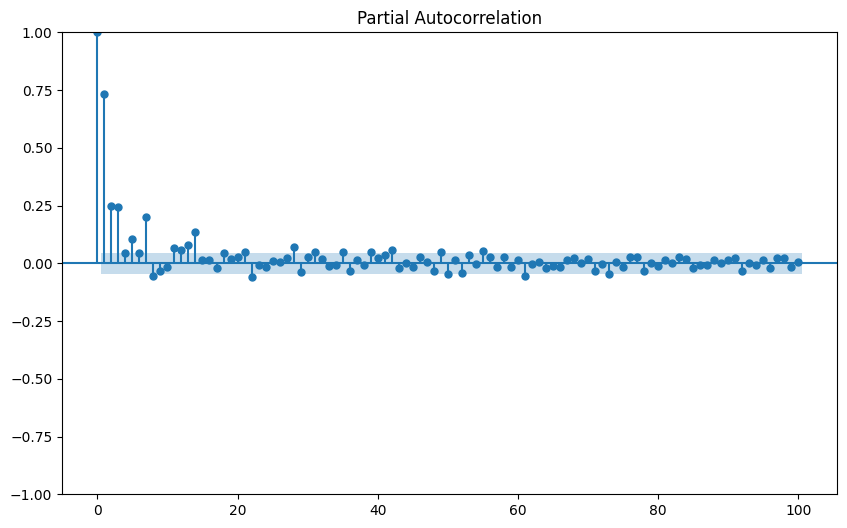

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(df['revenue'].dropna(), lags=100, ax=ax)
plt.show()

# Stationarity

In [14]:
# Adfuller test for stationarity
result = adfuller(df['revenue'].dropna()) 

# Extract results
# adf_stat = result[0]
p_value = result[1]
used_lag = result[2]
n_obs = result[3]
critical_values = result[4]
icbest = result[5]

# Print the results
# print('ADF Statistic: %f' % adf_stat)
print('p-value: %f' % p_value)
# print('Number of lags used: %d' % used_lag)
# print('Number of observations used: %d' % n_obs)
# print('Critical Values:')
# for key, value in critical_values.items():
#     print(f'   {key}: {value:.3f}')
# print('Information Criterion (best):', icbest)

# Interpretation
if p_value < 0.05:
    print("\nResult: Strong evidence against the null hypothesis (unit root), data is stationary.")
else:
    print("\nResult: Weak evidence against the null hypothesis, data is non-stationary (has a unit root).")


p-value: 0.101904

Result: Weak evidence against the null hypothesis, data is non-stationary (has a unit root).


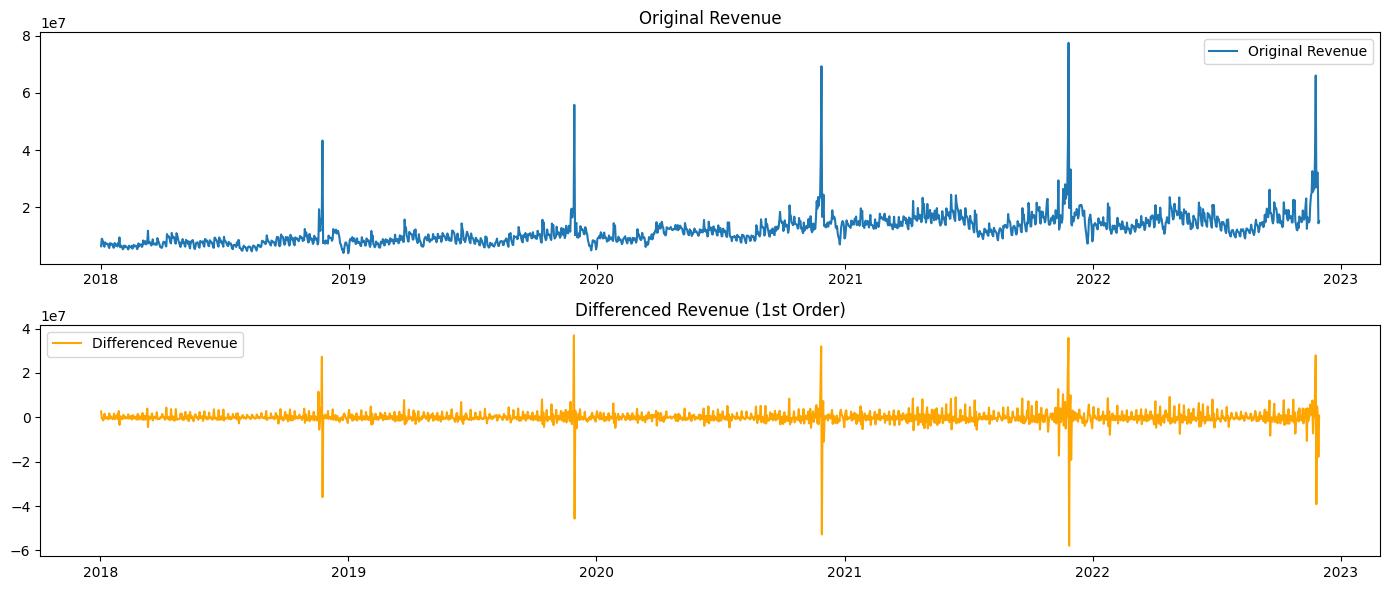

In [15]:
# Differencing to make df.revenue stationary
df['revenue_diff'] = df['revenue'].diff()

plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(df['revenue'], label='Original Revenue')
plt.title('Original Revenue')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df['revenue_diff'], label='Differenced Revenue', color='orange')
plt.title('Differenced Revenue (1st Order)')
plt.legend()

plt.tight_layout()
plt.show()

# ARIMA Model

In [16]:
#Splitting the data into training and testing sets
periods = 30
train, test = df.iloc[:-periods], df.iloc[-periods:]

test

,revenue,discount_rate,coupon_rate,revenue_diff
date,,,,
2022-11-01,16703680.0,23.85%,1.50%,4014654.0
2022-11-02,15827022.0,20.76%,0.94%,-876658.0
2022-11-03,16154319.0,21.85%,0.92%,327297.0
2022-11-04,14707212.0,20.17%,0.88%,-1447107.0
2022-11-05,14877530.0,17.85%,0.41%,170318.0
2022-11-06,18835528.0,16.40%,0.31%,3957998.0
2022-11-07,16094516.0,17.11%,0.30%,-2741012.0
2022-11-08,15589508.0,16.64%,0.29%,-505008.0
2022-11-09,16608320.0,18.72%,0.74%,1018812.0


In [17]:
# Using pmdarima to find the best ARIMA model and best parameters
model = auto_arima(train['revenue'], seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -28817.267
Date:                Sat, 21 Jun 2025   AIC                          57650.535
Time:                        17:39:26   BIC                          57694.337
Sample:                    01-01-2018   HQIC                         57666.720
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.120     -3.449      0.001      -0.649      -0.179
ar.L2          0.3017      0.053      5.671      0.000       0.197       0.406
ar.L3          0.1570      0.028      5.705      0.000       0.103       0.211
ar.L4          0.0679      0.029      2.365      0.018       0.012       0.124
ar.L5          0.0466      0.024      1.937      0.053      -0.001       0.094
ma.L1         -0.1598      0.118     -1.354      0.176      -0.391       0.071
ma.L2         -0.7423      0.108     -6.872      0.000      -0.954      -0.531
sigma2      9.084e+12   1.86e-14   4.88e+26      0.000    9.08e+12    9.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            580903.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             5.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.74e+42. Standard errors may be unstable.
"""

In [18]:
# Prediciton using the best ARIMA model
predictions = model.predict(n_periods=periods)
predictions

2022-11-01    1.445299e+07
2022-11-02    1.474103e+07
2022-11-03    1.503283e+07
2022-11-04    1.527520e+07
2022-11-05    1.534078e+07
2022-11-06    1.553442e+07
2022-11-07    1.554542e+07
2022-11-08    1.563967e+07
2022-11-09    1.565016e+07
2022-11-10    1.569221e+07
2022-11-11    1.570256e+07
2022-11-12    1.571953e+07
2022-11-13    1.572734e+07
2022-11-14    1.573420e+07
2022-11-15    1.573904e+07
2022-11-16    1.574197e+07
2022-11-17    1.574462e+07
2022-11-18    1.574600e+07
2022-11-19    1.574734e+07
2022-11-20    1.574804e+07
2022-11-21    1.574869e+07
2022-11-22    1.574906e+07
2022-11-23    1.574937e+07
2022-11-24    1.574956e+07
2022-11-25    1.574971e+07
2022-11-26    1.574981e+07
2022-11-27    1.574988e+07
2022-11-28    1.574994e+07
2022-11-29    1.574997e+07
2022-11-30    1.575000e+07
Freq: D, dtype: float64

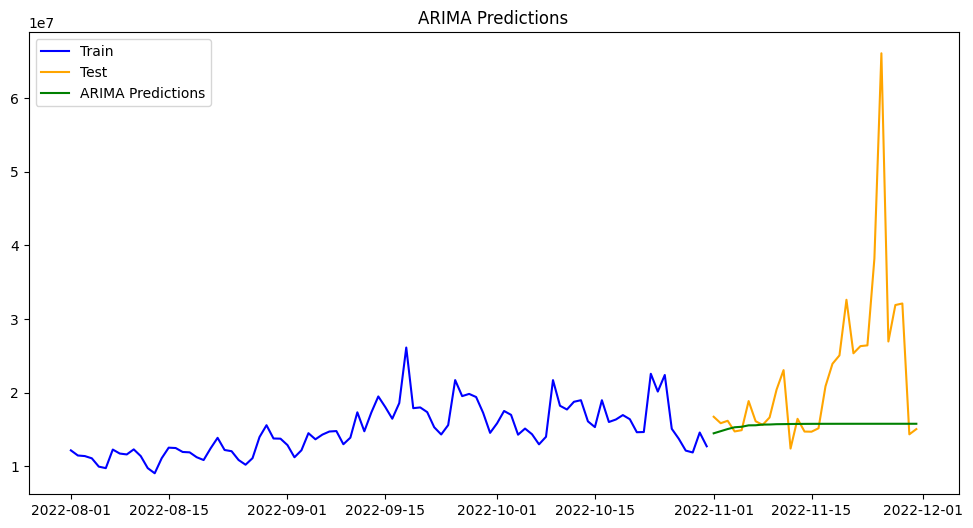

Mean Absolute Error (MAE) for ARIMA: 7267306.02
Root Mean Squared Error (RMSE) for ARIMA: 12366038.30
Mean Absolute Percentage Error (MAPE) for ARIMA: 24.15%


In [19]:
def assess_model(train, test, predictions, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Train', color='blue')
    plt.plot(test, label='Test', color='orange')
    plt.plot(predictions, label=f'{model_name} Predictions', color='green')
    plt.title(f'{model_name} Predictions')
    plt.legend()
    plt.show()

    mae = mean_absolute_error(test, predictions)
    print(f'Mean Absolute Error (MAE) for {model_name}: {mae:.2f}')
    rmse = mean_squared_error(test, predictions)  
    rmse = rmse ** 0.5
    print(f'Root Mean Squared Error (RMSE) for {model_name}: {rmse:.2f}')
    mape = mean_absolute_percentage_error(test, predictions)        
    print(f'Mean Absolute Percentage Error (MAPE) for {model_name}: {mape:.2%}') 


assess_model(train['revenue']['2022-08':], test['revenue']['2022-08':], predictions, 'ARIMA')